# In the Name of God
## Deep Learning HW4 - Problem 3
## Sayed Pouria fatemi 400206324


##Preprocessing

In [1]:
!pip install transformers
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 13.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertTokenizer, BertConfig
from torchmetrics import ConfusionMatrix

In [3]:
! git clone https://github.com/amnghd/Persian_poems_corpus

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 21.53 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
%cd '/content/Persian_poems_corpus/normalized'

/content/Persian_poems_corpus/normalized


In [5]:
config = BertConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [6]:
poet_list = ['ferdousi', 'jami', 'eraghi', 'iqbal', 'attar', 
            'seyf', 'moulavi', 'parvin', 'bahar', 'saadi']

min_len = 1e7
df_list = []
for i in range(10):
  df_list.append(pd.read_csv(poet_list[i] + '_norm.txt', header=None, names=['hemistich']))
  df_list[i] = df_list[i].groupby(df_list[i].index // 2).agg(' '.join)
  df_list[i]['poet'] = i
  if min_len > len(df_list[i]):
    min_len = len(df_list[i])

for i in range(10):
  df_list[i] = df_list[i].sample(n=min_len)

df = pd.concat(df_list, axis=0).sample(frac=1).reset_index(drop= True)
df

,hemistich,poet
0,گاه باید زد به میخ و گه به نعل گر سند خواهند ب...,7
1,گهی از آدم و مرگاه ازنوح که تا او را فزاید قوت...,4
2,به گرد پای سمندش نمی رسد مشتاق که دستبوس کند ت...,9
3,جان ما را لذت اندر جستجوست شعر را سوز از مقام ...,3
4,جان بابا چون بخسپد ساحری سحر و مکرش را نباشد ر...,6
...,...,...
55725,از درخت انی انا الله می شنید با کلام انوار می ...,6
55726,تو آگاهی نداری ای دل مست که یارت در برون و در ...,4
55727,پیش قصری رسید و در نگرید صورت دختر اتابک دید,2
55728,گزارنده خواب و جنگی توی گه چاره مرد درنگی توی,0


In [7]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer):
        self.tokenizer = tokenizer
        self.text = dataframe.hemistich
        self.targets = dataframe.poet

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length= 50,
            padding='max_length',
            return_token_type_ids=True,
            return_tensors='pt'
        )

        return inputs['input_ids'].flatten(), inputs['attention_mask'].flatten(), inputs["token_type_ids"].flatten(), torch.tensor(self.targets.iloc[index])

In [8]:
train_df = df[:int(0.6 * len(df))] 
validation_df = df[int(0.6 * len(df)) : int(0.7 * len(df))] 
test_df = df[int(0.7 * len(df)):] 

train_dataset = CustomDataset(train_df, tokenizer)
validation_dataset = CustomDataset(validation_df, tokenizer)
test_dataset = CustomDataset(test_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=True)

##Part (a)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class NNClass(nn.Module):
    def __init__(self, base_model):
        super(NNClass, self).__init__()
        self.l1 = base_model
        self.l2 = nn.Sequential(nn.Dropout(0.5),
                                 nn.Linear(768, 10),
                          )
    
    def forward(self, ids, mask, token_type_ids):
        output = self.l1(input_ids = ids, attention_mask = mask, token_type_ids = token_type_ids)
        output = output['pooler_output']
        output = self.l2(output)
        return output

In [10]:
class nn_optimizer():
  def __init__(self, model, train_dataloader, validation_dataloader, epochs, learning_rate, optimizer):
    self.model = model
    self.epochs = epochs
    self.train_loss = []
    self.validation_loss = []
    self.train_accuracy = []
    self.validation_accuracy = []
    self.loss_fn = nn.CrossEntropyLoss()
    self.confmat = ConfusionMatrix(task="multiclass", num_classes=10).to(device)
    if optimizer == 'SGD':
      self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
    if optimizer == 'ADAM':
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    self.train_dataloader = train_dataloader
    self.validation_dataloader = validation_dataloader

  def train_loop(self):
    self.model.train()
    size = len(self.train_dataloader.dataset)
    for batch, (ids, mask, token_type_ids, targets) in enumerate(self.train_dataloader):
      ids = ids.to(device)
      mask = mask.to(device)
      token_type_ids = token_type_ids.to(device)
      y = targets.to(device)
      pred = self.model(ids, mask, token_type_ids)
      loss = self.loss_fn(pred, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(y)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  def evaluate(self, model, dataloader, name= None):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0
    cm = torch.zeros((10, 10), dtype=int).to(device)

    with torch.no_grad():
      for (ids, mask, token_type_ids, targets) in dataloader:
        ids = ids.to(device)
        mask = mask.to(device)
        token_type_ids = token_type_ids.to(device)
        y = targets.to(device)
        pred = model(ids, mask, token_type_ids)
        loss += self.loss_fn(pred, y).item()
        y_pred = pred.argmax(1)
        correct += (y_pred == y).type(torch.float).sum().item()
        if name == 'Test':
          cm += self.confmat(y , y_pred)

    loss /= num_batches
    accuracy = correct / size
    if name == 'Test':
      TP = torch.diag(cm)
      FP = torch.sum(cm, axis=0) - TP
      FN = torch.sum(cm, axis=1) - TP
      precision = torch.sum(TP)/(torch.sum(TP)+torch.sum(FP))
      recall = torch.sum(TP)/(torch.sum(TP)+torch.sum(FN))
      micro_F1_score = (2 * recall * precision / (recall + precision)).item()
      return loss, accuracy, micro_F1_score, cm
    else:
      if name:
        print(f"{name} Accuracy: {(100*accuracy):>0.2f}%, Avg {name} loss: {loss:>8f}")
      return loss, accuracy
    

  def fit(self):
    for t in range(self.epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      self.train_loop()
      train_loss, train_accuracy = self.evaluate(self.model, self.train_dataloader, 'Train')
      self.train_loss.append(train_loss)
      self.train_accuracy.append(train_accuracy)
      val_loss, val_accuracy = self.evaluate(self.model, self.validation_dataloader, 'Validation')
      self.validation_loss.append(val_loss)
      self.validation_accuracy.append(val_accuracy)
      print("**************************************************")

In [ ]:
base_model1 = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
for param in base_model1.parameters():
    param.requires_grad = False

model1 = NNClass(base_model1).to(device)
nn_opt1 = nn_optimizer(model1, train_dataloader, validation_dataloader, 15, 1e-4, 'ADAM')
nn_opt1.fit()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1
-------------------------------
loss: 2.339603  [    0/33438]
loss: 2.420840  [ 5000/33438]
loss: 2.271732  [10000/33438]
loss: 2.262481  [15000/33438]
loss: 2.312727  [20000/33438]
loss: 2.292031  [25000/33438]
loss: 2.304234  [30000/33438]
Train Accuracy: 22.87%, Avg Train loss: 2.198287
Validation Accuracy: 22.36%, Avg Validation loss: 2.200817
**************************************************
Epoch 2
-------------------------------
loss: 2.248696  [    0/33438]
loss: 2.276818  [ 5000/33438]
loss: 2.241695  [10000/33438]
loss: 2.209905  [15000/33438]
loss: 2.263672  [20000/33438]
loss: 2.296821  [25000/33438]
loss: 2.228174  [30000/33438]
Train Accuracy: 26.14%, Avg Train loss: 2.138771
Validation Accuracy: 25.59%, Avg Validation loss: 2.144773
**************************************************
Epoch 3
-------------------------------
loss: 2.222771  [    0/33438]
loss: 2.262087  [ 5000/33438]
loss: 2.143862  [10000/33438]
loss: 2.131425  [15000/33438]
loss: 2.204267  [20000

In [ ]:
loss1, accuracy1, micro_F1_score1, cm1 = nn_opt1.evaluate(model1, test_dataloader, 'Test')
print('Linear-Tune:')
print(f"Avg Test loss: {loss1:>8f}")
print(f"Test Accuracy: {(100*accuracy1):>0.2f}%")
print(f"micro F1 score: {micro_F1_score1}")

Linear-Tune:
Avg Test loss: 1.978278
Test Accuracy: 31.64%
micro F1 score: 0.3164064884185791


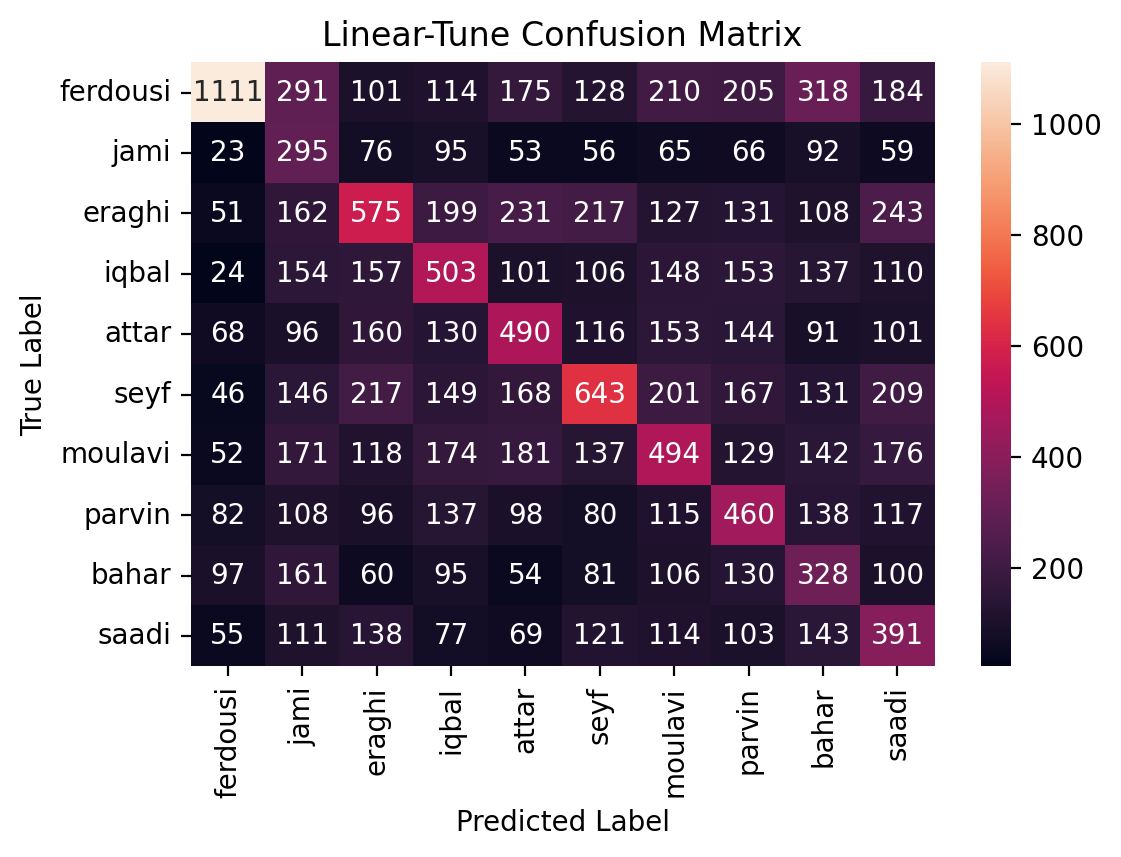

In [ ]:
plt.figure(dpi = 200)
sn.heatmap(cm1.detach().cpu().numpy(), annot= True, fmt= 'd',
           xticklabels= poet_list,
           yticklabels= poet_list)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Linear-Tune Confusion Matrix")
plt.show()

##Part (b)

In [11]:
base_model2 = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
for param in base_model2.parameters():
    param.requires_grad = True

model2 = NNClass(base_model2).to(device)
nn_opt2 = nn_optimizer(model2, train_dataloader, validation_dataloader, 8, 1e-5, 'ADAM')
nn_opt2.fit()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1
-------------------------------
loss: 2.463159  [    0/33438]
loss: 2.155060  [ 5000/33438]
loss: 2.077083  [10000/33438]
loss: 1.859768  [15000/33438]
loss: 1.667798  [20000/33438]
loss: 1.817480  [25000/33438]
loss: 1.425389  [30000/33438]
Train Accuracy: 54.25%, Avg Train loss: 1.376152
Validation Accuracy: 48.63%, Avg Validation loss: 1.498169
**************************************************
Epoch 2
-------------------------------
loss: 1.346206  [    0/33438]
loss: 1.334035  [ 5000/33438]
loss: 1.362711  [10000/33438]
loss: 1.357988  [15000/33438]
loss: 1.398028  [20000/33438]
loss: 1.340325  [25000/33438]
loss: 1.199102  [30000/33438]
Train Accuracy: 65.69%, Avg Train loss: 1.026863
Validation Accuracy: 53.96%, Avg Validation loss: 1.344853
**************************************************
Epoch 3
-------------------------------
loss: 1.136151  [    0/33438]
loss: 0.896261  [ 5000/33438]
loss: 1.114583  [10000/33438]
loss: 0.743802  [15000/33438]
loss: 0.806021  [20000

In [12]:
loss2, accuracy2, micro_F1_score2, cm2 = nn_opt2.evaluate(model2, test_dataloader, 'Test')
print('Fine-Tune with ADAM:')
print(f"Avg Test loss: {loss2:>8f}")
print(f"Test Accuracy: {(100*accuracy2):>0.2f}%")
print(f"micro F1 score: {micro_F1_score2}")

Fine-Tune with ADAM:
Avg Test loss: 1.504947
Test Accuracy: 63.82%
micro F1 score: 0.6381960511207581


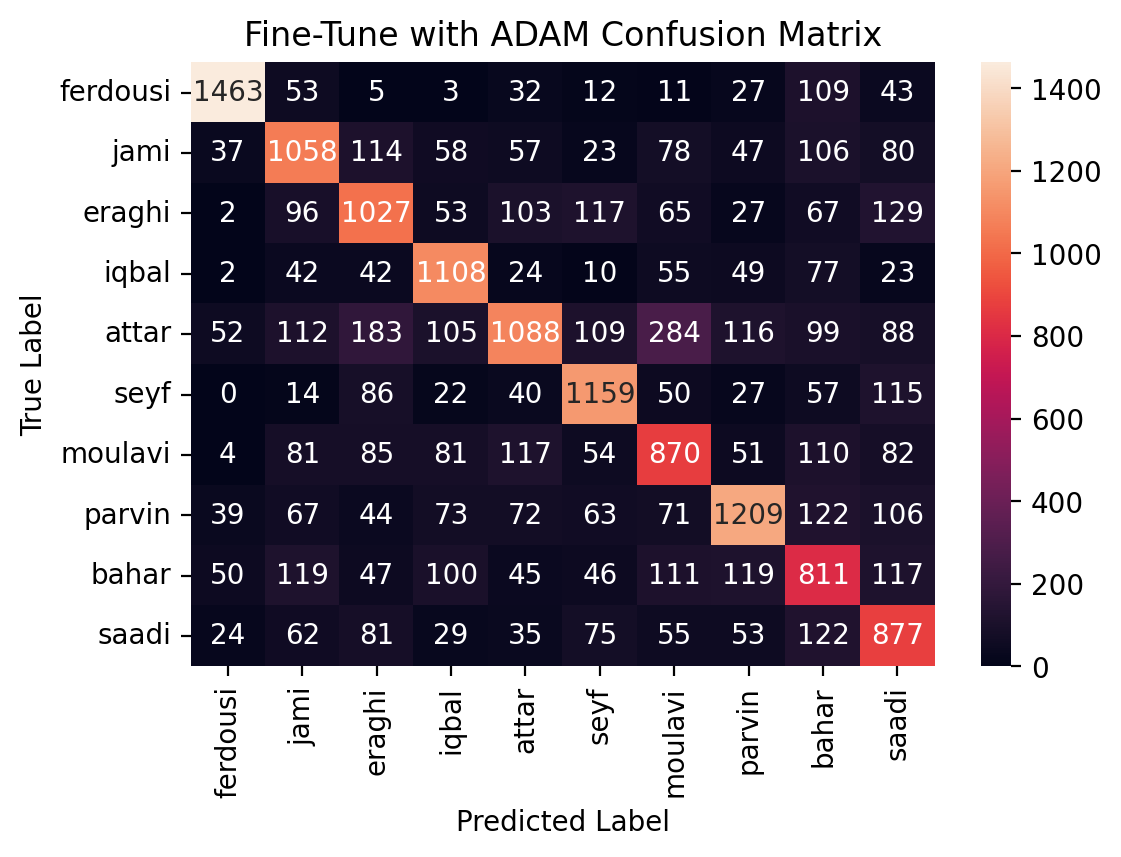

In [13]:
plt.figure(dpi = 200)
sn.heatmap(cm2.detach().cpu().numpy(), annot= True, fmt= 'd',
           xticklabels= poet_list,
           yticklabels= poet_list)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Fine-Tune with ADAM Confusion Matrix")
plt.show()

In [ ]:
base_model3 = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
for param in base_model3.parameters():
    param.requires_grad = True

model3 = NNClass(base_model3).to(device)
nn_opt3 = nn_optimizer(model3, train_dataloader, validation_dataloader, 8, 1e-5, 'SGD')
nn_opt3.fit()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1
-------------------------------
loss: 2.423950  [    0/33438]
loss: 2.368379  [ 5000/33438]
loss: 2.450332  [10000/33438]
loss: 2.428616  [15000/33438]
loss: 2.404685  [20000/33438]
loss: 2.267767  [25000/33438]
loss: 2.334827  [30000/33438]
Train Accuracy: 9.21%, Avg Train loss: 2.329906
Validation Accuracy: 8.92%, Avg Validation loss: 2.330038
**************************************************
Epoch 2
-------------------------------
loss: 2.467021  [    0/33438]
loss: 2.431897  [ 5000/33438]
loss: 2.421287  [10000/33438]
loss: 2.362419  [15000/33438]
loss: 2.476885  [20000/33438]
loss: 2.350219  [25000/33438]
loss: 2.312379  [30000/33438]
Train Accuracy: 9.56%, Avg Train loss: 2.320275
Validation Accuracy: 9.13%, Avg Validation loss: 2.319387
**************************************************
Epoch 3
-------------------------------
loss: 2.356230  [    0/33438]
loss: 2.405124  [ 5000/33438]
loss: 2.432188  [10000/33438]
loss: 2.414802  [15000/33438]
loss: 2.399833  [20000/334

In [ ]:
loss3, accuracy3, micro_F1_score3, cm3 = nn_opt3.evaluate(model3, test_dataloader, 'Test')
print('Linear tuning with SGD:')
print(f"Avg Test loss: {loss3:>8f}")
print(f"Test Accuracy: {(100*accuracy3):>0.2f}%")
print(f"micro F1 score: {micro_F1_score3}")

Linear tuning with SGD:
Avg Test loss: 2.301620
Test Accuracy: 11.59%
micro F1 score: 0.11591602116823196


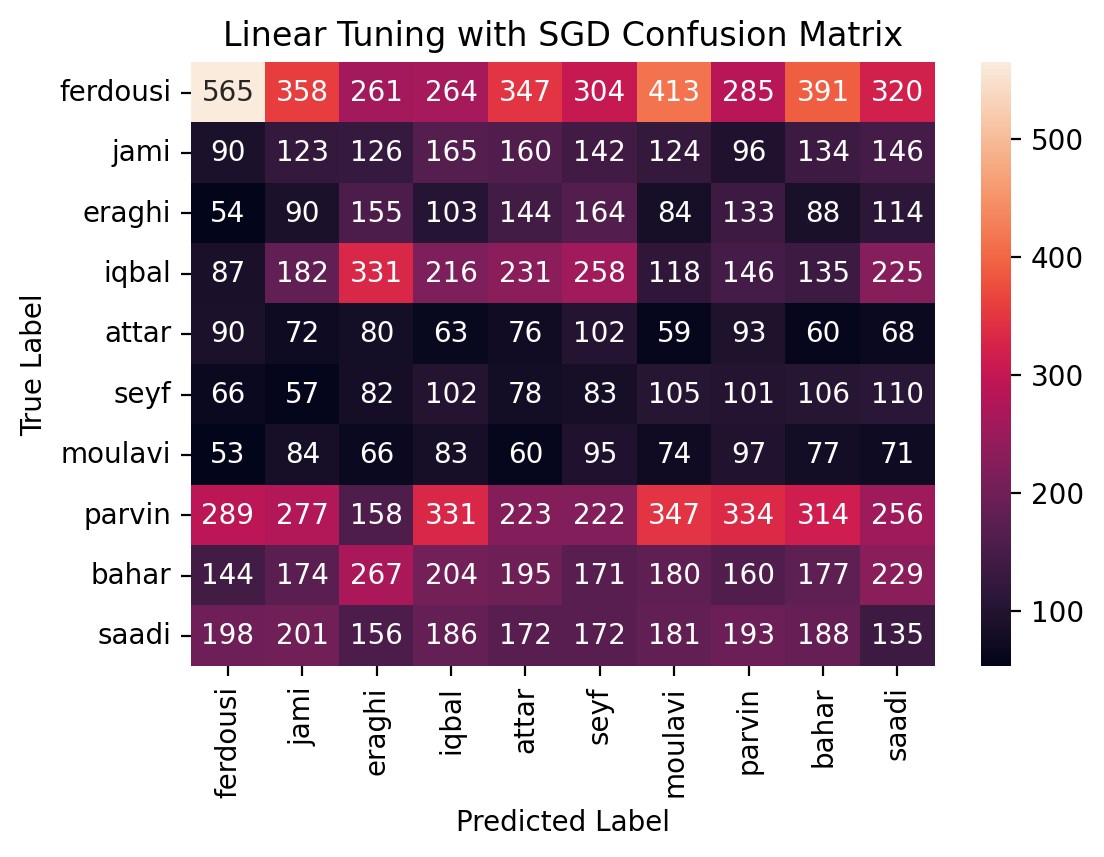

In [ ]:
plt.figure(dpi = 200)
sn.heatmap(cm3.detach().cpu().numpy(), annot= True, fmt= 'd',
           xticklabels= poet_list,
           yticklabels= poet_list)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Linear Tuning with SGD Confusion Matrix")
plt.show()

##Part (c)

In [14]:
poet_list = ['ferdousi', 'jami', 'eraghi', 'iqbal', 'attar', 
            'seyf', 'moulavi', 'parvin', 'bahar', 'saadi']

df_list = []
for i in range(10):
  df_list.append(pd.read_csv(poet_list[i] + '_norm.txt', header=None, names=['hemistich']))
  df_list[i] = df_list[i].groupby(df_list[i].index // 2).agg(' '.join)

for i in range(10):
  df_list[i] = df_list[i].sample(n=100)

df_test = pd.concat(df_list, axis=0).sample(frac=1).reset_index(drop= True)

In [15]:
base_model2.save_pretrained('/content/fine_tune_model')
tokenizer.save_pretrained('/content/fine_tune_model')

('/content/fine_tune_model/tokenizer_config.json',
 '/content/fine_tune_model/special_tokens_map.json',
 '/content/fine_tune_model/vocab.txt',
 '/content/fine_tune_model/added_tokens.json')

In [16]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [19]:
from evaluate import load

perplexity = load("perplexity", module_type="metric")

results = perplexity.compute(model_id= "HooshvareLab/bert-fa-base-uncased",
                             add_start_token= False,
                             predictions= df_test.hemistich)

print(f"\n Mean perplexity before fine tuning: {results['mean_perplexity']}")

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/63 [00:00<?, ?it/s]


 Mean perplexity before fine tuning: 3150003.157354492


In [20]:
results = perplexity.compute(model_id= "/content/fine_tune_model",
                             add_start_token= False,
                             predictions= df_test.hemistich)

print(f"\n Mean perplexity after fine tuning: {results['mean_perplexity']}")

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of BertLMHeadModel were not initialized from the model checkpoint at /content/fine_tune_model and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/63 [00:00<?, ?it/s]


 Mean perplexity after fine tuning: 109413.47812109375


<div dir="rtl"> <font size="4" face="vazirmatn">    
همان‌طور که انتظار داشتیم بعد از 
fine-tuning
شگفت‌زدگی مدل روی دیتای شعر کمتر می‌شود. با توجه به این‌که مدل را با داده‌ی شعر 
fine-tune
کرده‌ایم طبیعی است که شعر جدید مدل را کمتر شگفت‌زده کند نسبت به مدلی که روی دیتای کلی آموزش دیده است. 
</font> </div> 